# Benchmarks
- BERT only: Message embeddings
- BERT with fingers and tails: Message with tails and fingers
- Custom decision tree strategy

# Dataset Paths
- data.csv: Train set for part 1
- test.csv: Test set for part 1
- pred.csv: Prediction path for part 1

In [123]:
# Part 1
# Change according to system; paths set according to colab
data_path = "/content/drive/MyDrive/eightfold/data.csv" #data.csv for Part 1
test_path = "/content/drive/MyDrive/eightfold/test.csv" #test.csv for Part 1
pred_path = "/content/drive/MyDrive/eightfold/result.csv" #Save test results to this path

# Imports

In [124]:
# Mount for drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
import warnings
warnings.filterwarnings('ignore')

In [126]:
df = pd.read_csv(data_path)

In [127]:
results = {}

# Simple BERT Model
BERT model extracts the message embeddings which will help to detect species using XGB Classifier

In [128]:
# Import light version of BERT for message embeddings
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")

In [129]:
# Label Encoding Tail and Species columns
from sklearn.preprocessing import LabelEncoder

le_tail = LabelEncoder()
le_species = LabelEncoder()
df['tail'] = le_tail.fit_transform(df['tail'])
df['species'] = le_species.fit_transform(df['species'])

In [130]:
from tqdm.notebook import tqdm

# Find message embeddings using BERT
def encode_message(message):
  inputs = tokenizer(message, return_tensors="pt", padding=True, truncation=True)
  outputs = model(**inputs)
  return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

tqdm.pandas()
df["message_embedding"] = df["message"].progress_apply(encode_message)

  0%|          | 0/500 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [131]:
# Using only message embeddings to detect species using XGB
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare the data
X = []
for i in range(len(df)):
  X.append(df["message_embedding"][i])
y = df["species"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

train_accuracy = accuracy_score(y_train, model.predict(X_train))
print("Train Accuracy:", train_accuracy)

results["BERT only"] = {
    "train": train_accuracy,
    "val": accuracy
}

Accuracy: 0.5
Train Accuracy: 1.0


# BERT Model with inclusion of Fingers and Tails
Addition of Fingers and Tail context to columns to improve accuracy

In [132]:
# Using message embeddings, fingers and tails to predict species using XGB
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare the data
X = []
for i in range(len(df)):
  X.append(np.concatenate((df["message_embedding"][i], [df["fingers"][i]], [df["tail"][i]])))
y = df["species"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

train_accuracy = accuracy_score(y_train, model.predict(X_train))
print("Train Accuracy:", train_accuracy)

results["BERT, fingers and tails"] = {
    "train": train_accuracy,
    "val": accuracy
}

Accuracy: 0.74
Train Accuracy: 1.0


# Custom Decision Tree Model
Decision based Strategy to accurately predict species based on Xernian demographics and species vocabulary

In [133]:
import tqdm

In [134]:
df = pd.read_csv(data_path)

In [135]:
# Store the vocabulary of all species
vocab = {}
for species in tqdm.tqdm(df["species"].unique()):
  bla = df[df["species"] == species]
  vocab[species] = set([])
  for i, row in bla.iterrows():
    for word in row["message"].split(' '):
      vocab[species].add(word)

100%|██████████| 10/10 [00:00<00:00, 55.43it/s]


In [136]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [137]:
# Finding intersection of vocabularies of all species
from itertools import combinations

species_combinations = list(combinations(vocab.keys(), 2))

for species1, species2 in species_combinations:
  intersection = vocab[species1].intersection(vocab[species2])
  if intersection:
    print(f"Intersection between {species1} and {species2}: {intersection}")
    if (vocab[species1] == vocab[species2]):
      print("Same Vocab")

# The species can be divided into 5 distinct groups of shared vocabularies.
# Narrowing down to the wider group will help to distinguish between the species based on fingers and tails using XGB

Intersection between Aquari and Florian: {'pluvia', 'herba', 'haunar', 'gaiax', 'terranix', 'floren', 'ekos', 'petros', 'aviana', 'foliar', 'leafon', 'ariana', 'seypod', 'sporzom', 'biomar', 'rootix', 'terram', 'ventus', 'floraz', 'pollex', 'aquos', 'insectus', 'solux', 'zephyr', 'floran', 'nimbus', 'arbor', 'faunar', 'seepod'}
Intersection between Zorblax and Quixnar: {'novara', 'novum', 'galaxum', 'celestar', 'nebulax', 'kkmeta', 'stardux', 'blapoz', 'vortex', 'novax', 'astron', 'kometa', 'zorp', 'xeno', 'lunox', 'ufox', 'cosmix', 'solarix', 'warpz', 'nebuz', 'meteorn', 'quasar', 'orbitaz', 'glixx', 'pulsox', 'pulsar'}
Intersection between Faerix and Mythron: {'mythox', 'mermax', 'fabulon', 'gryphox', 'elvex', 'herox', 'faerix', 'drakos', 'goblax', 'centarex', 'legax', 'beastix', 'cyclopix', 'deitax', 'epikoz', 'unikor', 'titanos', 'nympha', 'sirenix', 'sagax', 'lorix', 'magix', 'krakos', 'relikum', 'fenix'}
Intersection between Nexoon and Cybex: {'aeon', 'nanozom', 'algorix', 'datax

In [138]:
same_vocab = {}
same_vocab["Florian"] = "Aquari"
same_vocab["Quixnar"] = "Zorblax"
same_vocab["Emotivor"] = "Sentire"
same_vocab["Cybex"] = "Nexoon"
same_vocab["Faerix"] = "Mythron"

for species in list(same_vocab.keys()):
  same_vocab[same_vocab[species]] = species

In [139]:
same_vocab

{'Florian': 'Aquari',
 'Quixnar': 'Zorblax',
 'Emotivor': 'Sentire',
 'Cybex': 'Nexoon',
 'Faerix': 'Mythron',
 'Aquari': 'Florian',
 'Zorblax': 'Quixnar',
 'Sentire': 'Emotivor',
 'Nexoon': 'Cybex',
 'Mythron': 'Faerix'}

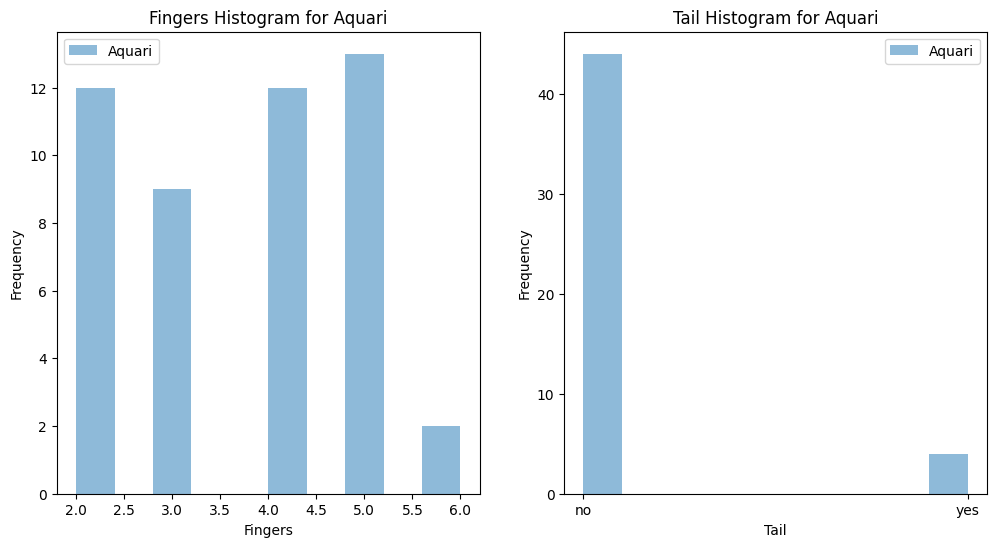

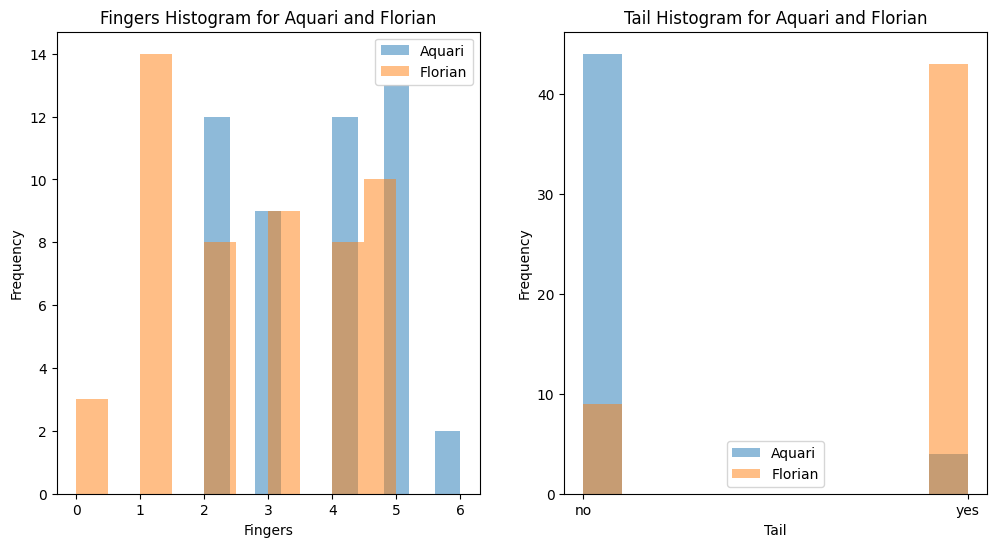

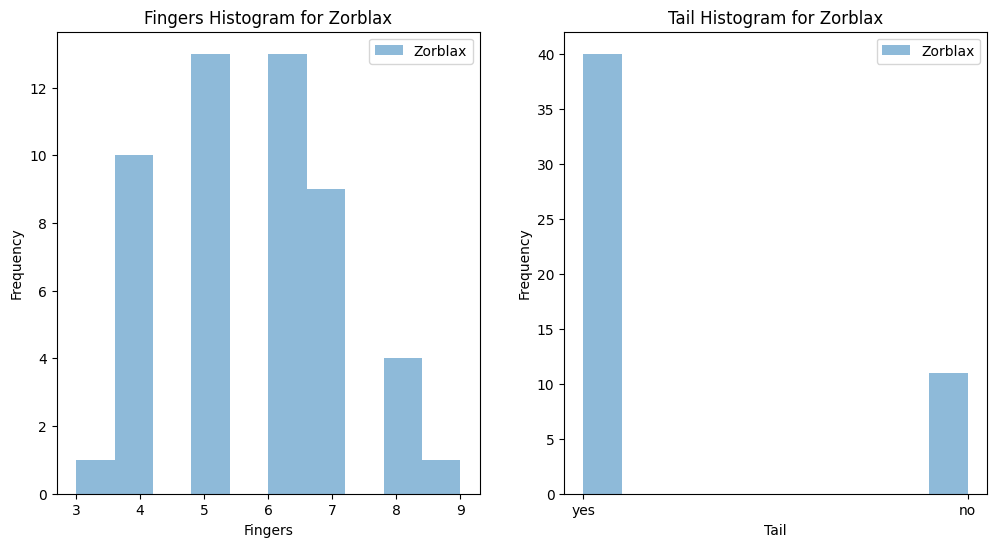

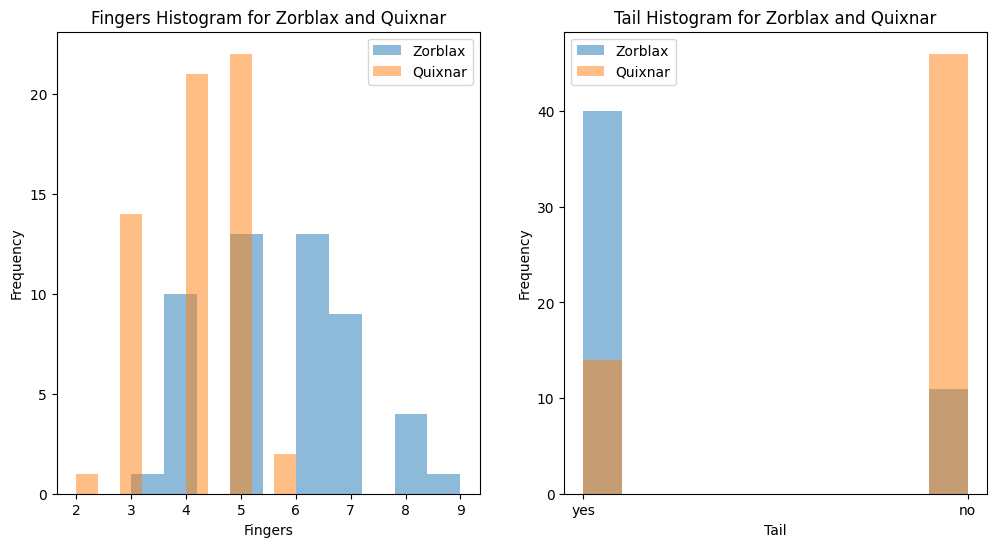

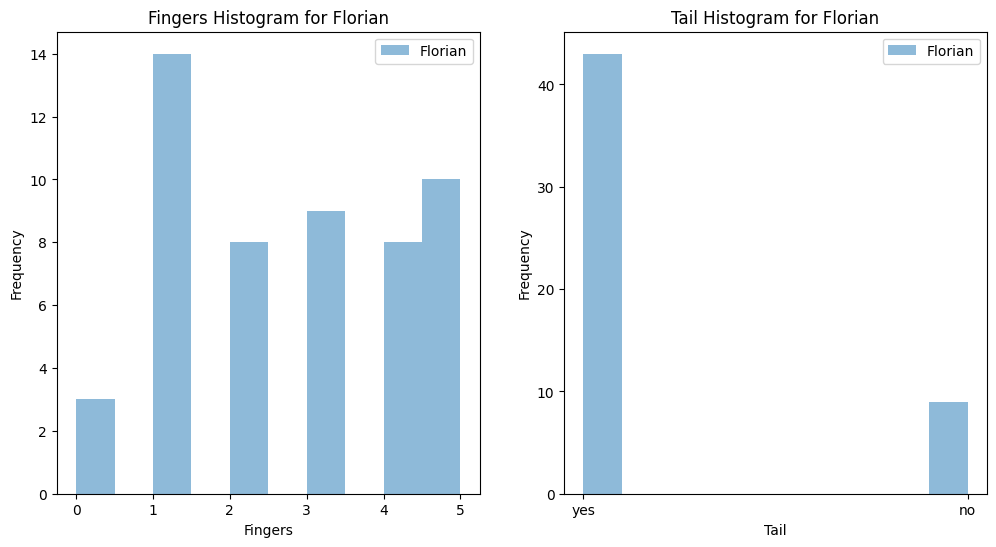

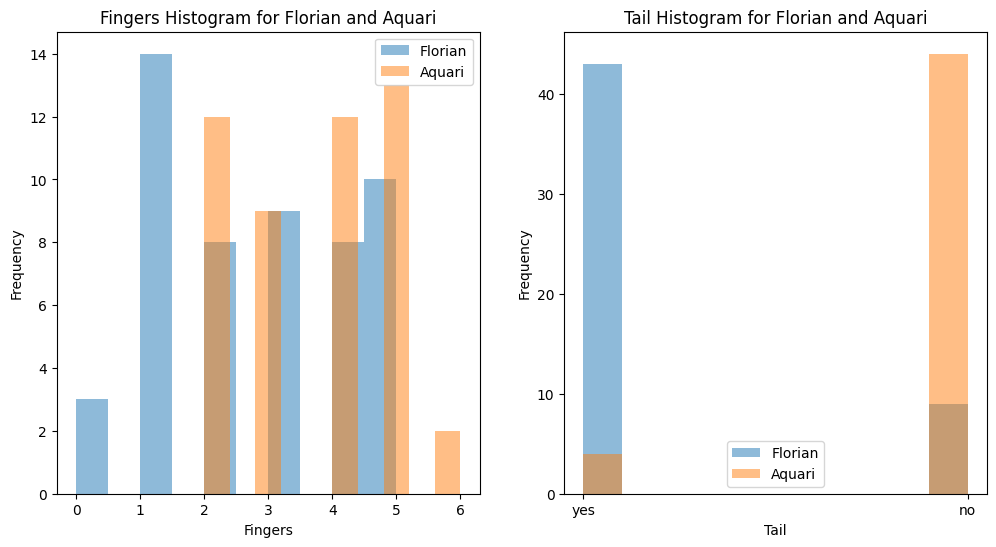

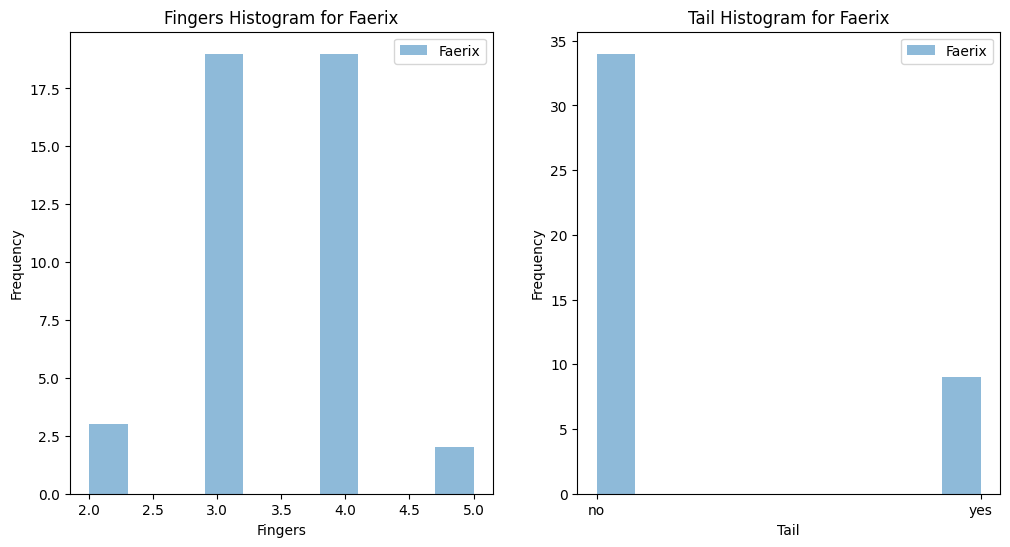

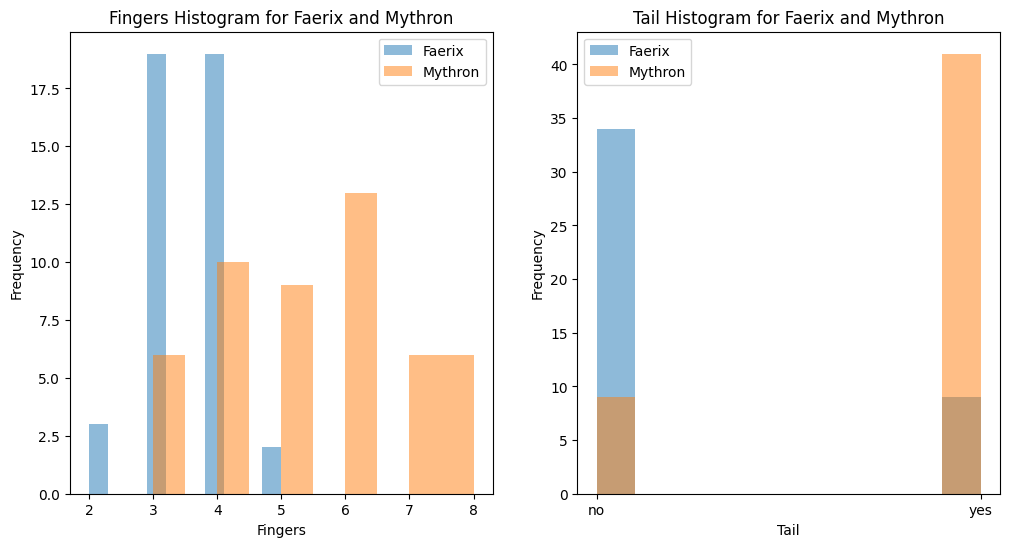

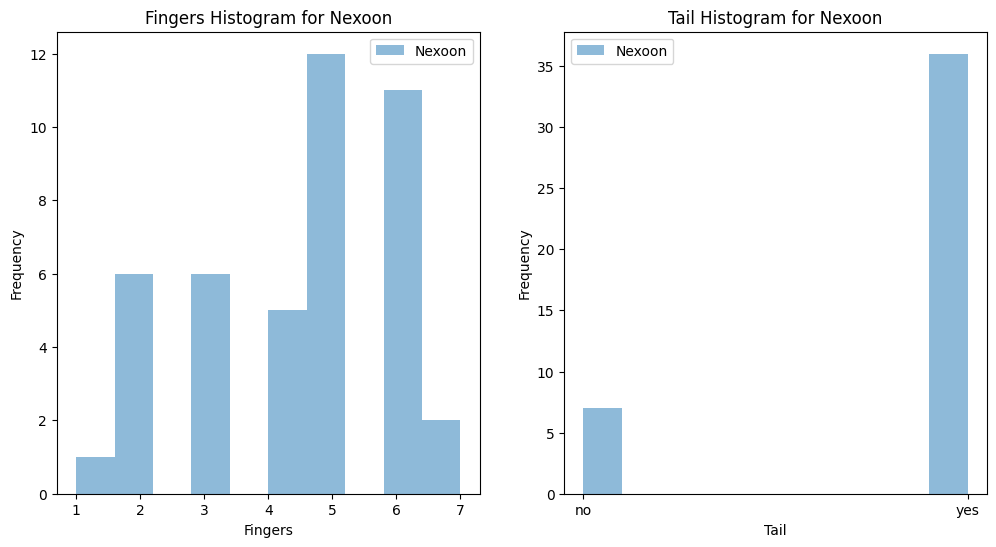

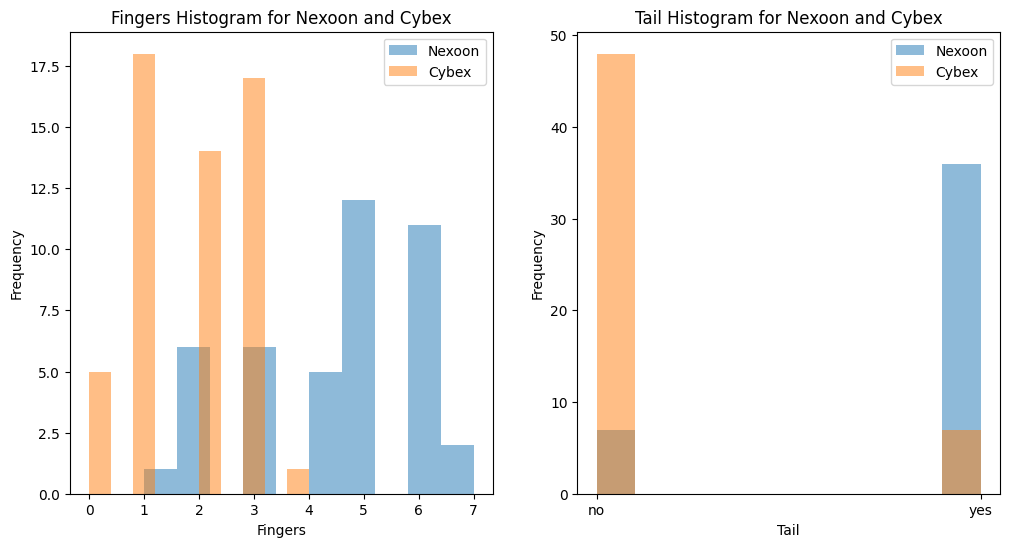

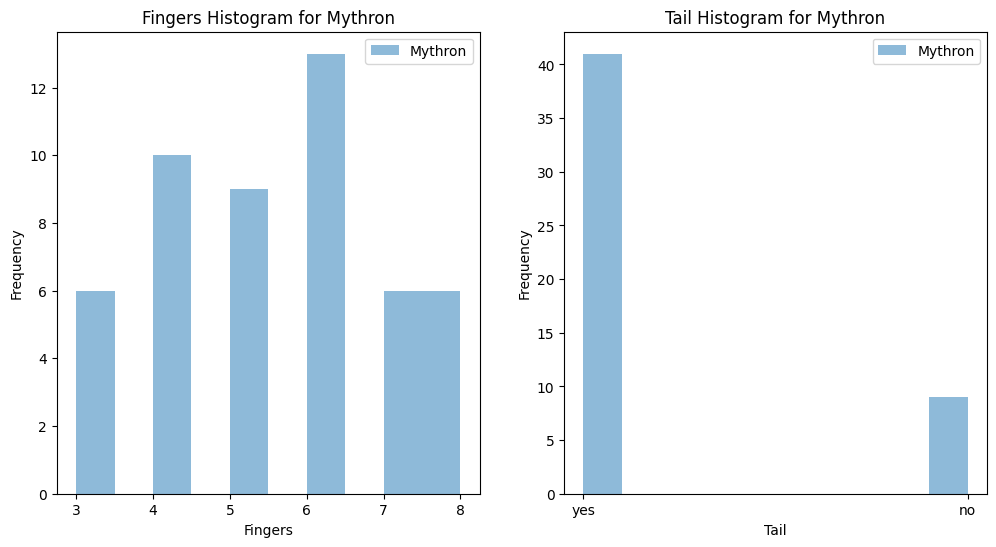

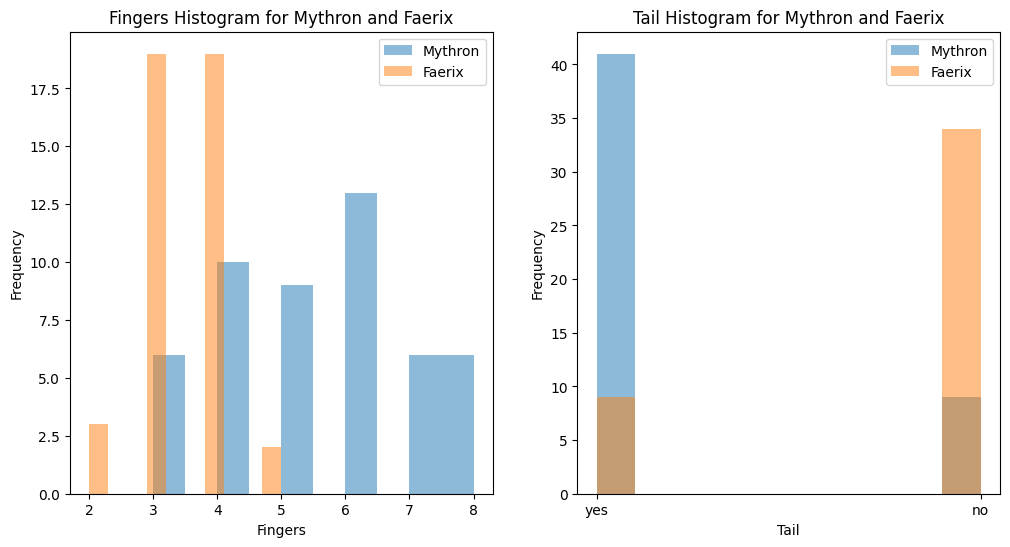

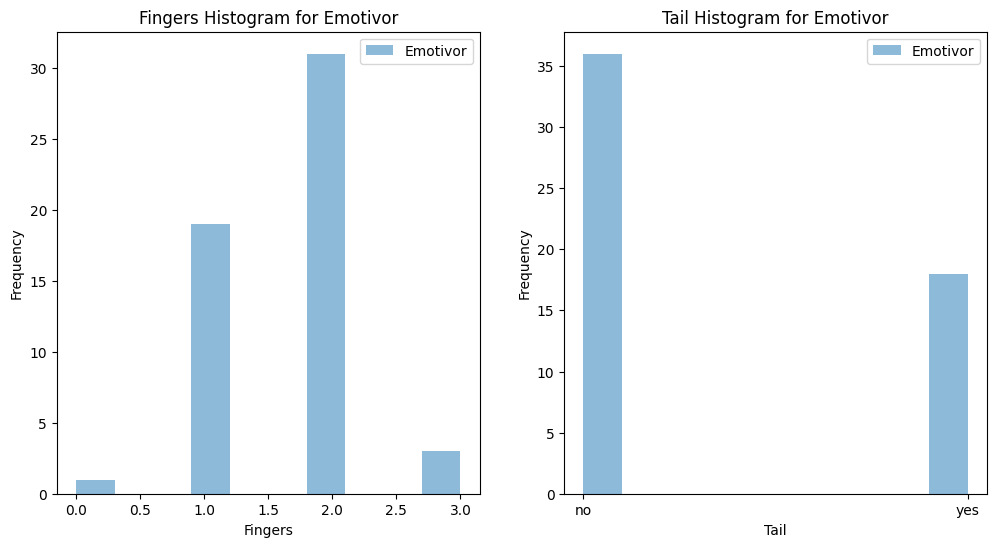

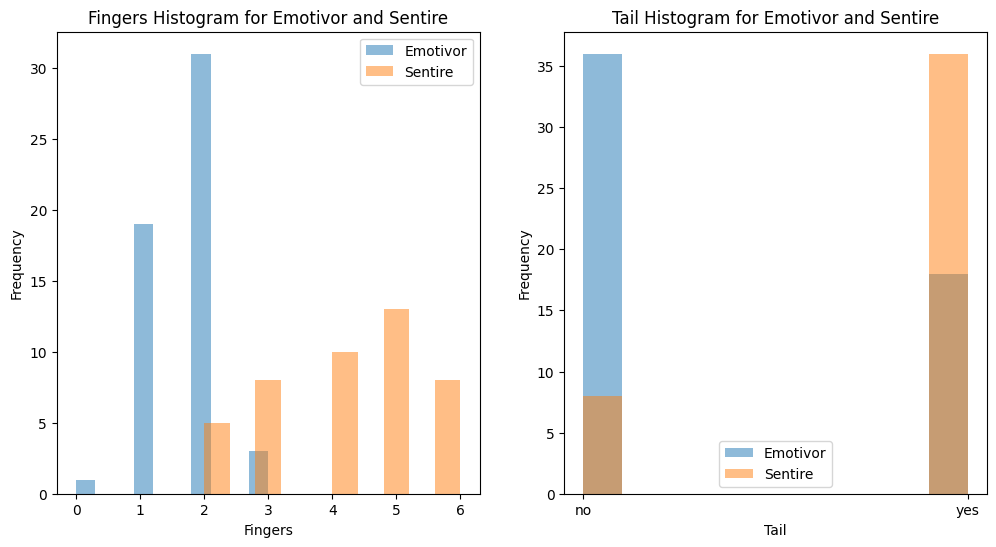

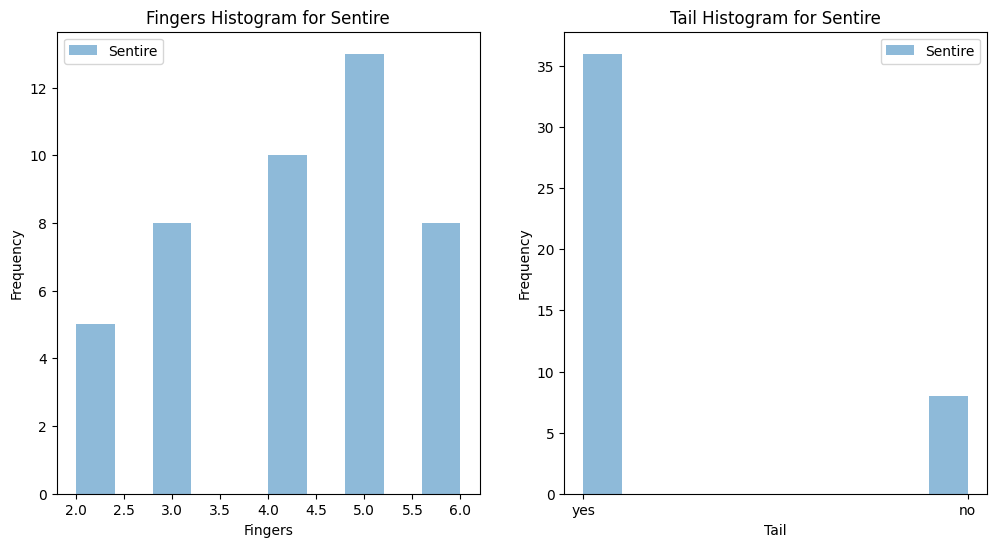

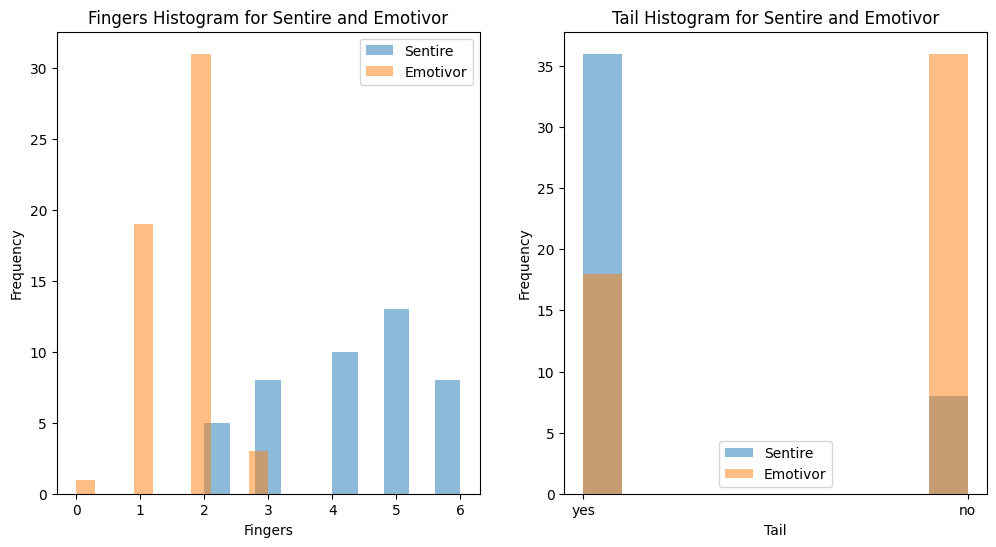

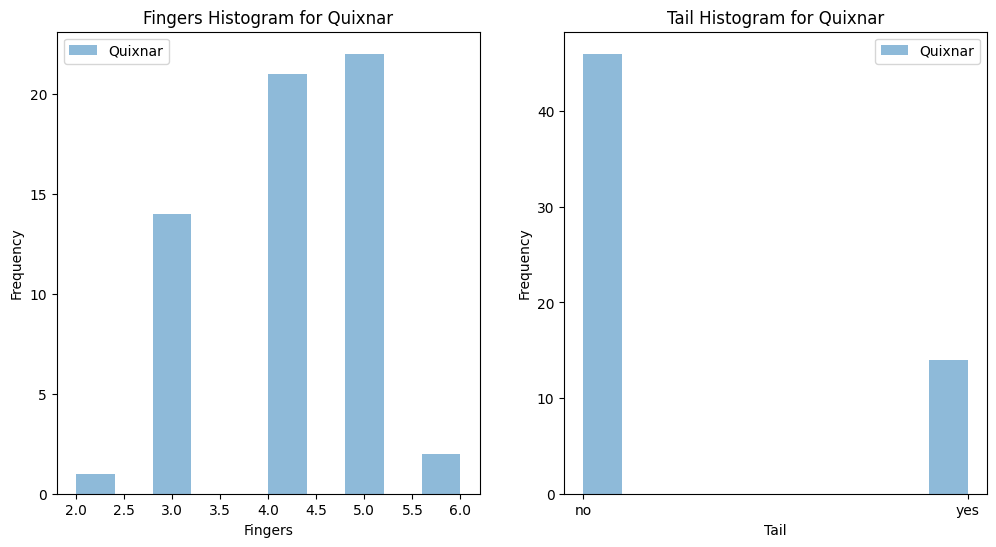

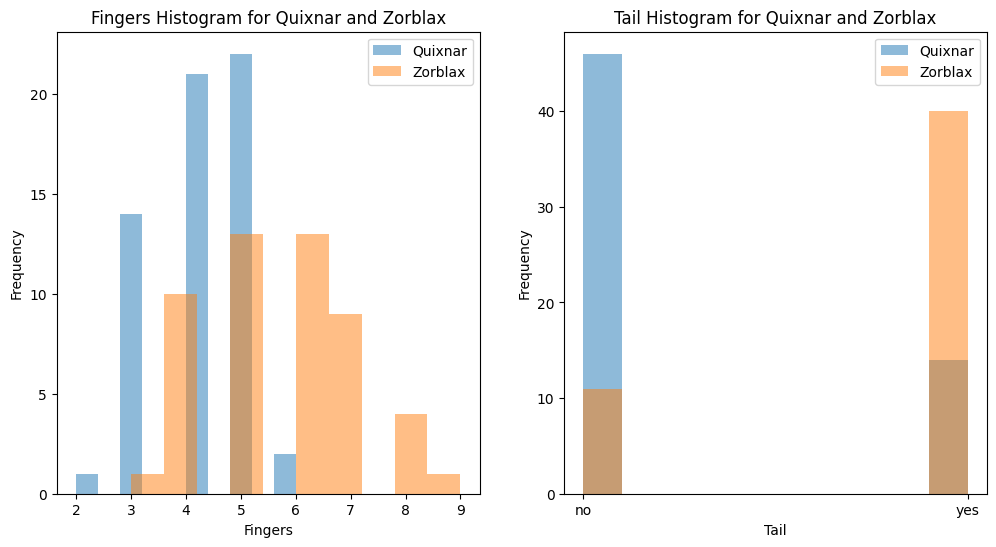

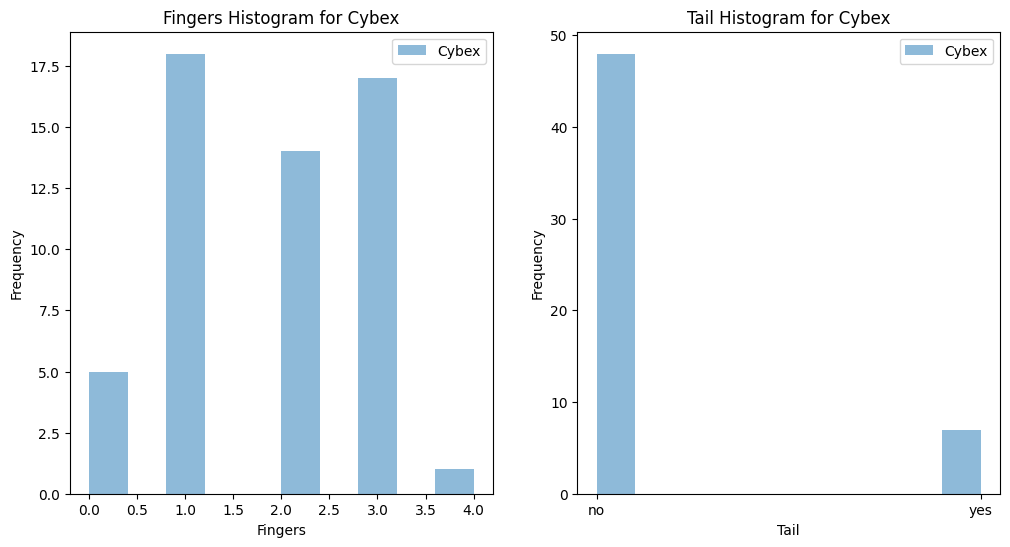

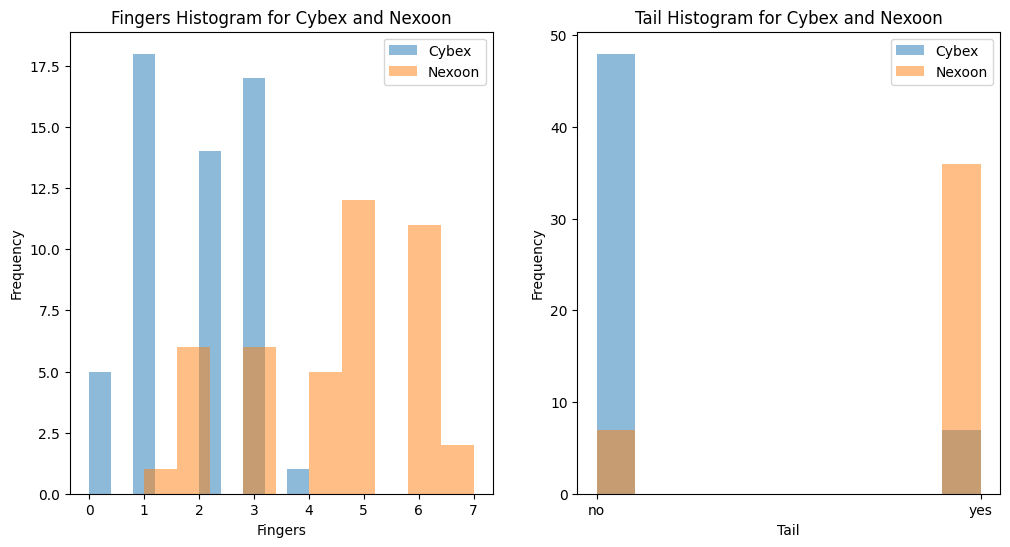

In [140]:
# For all species, we plot the histograms of fingers and tails
import matplotlib.pyplot as plt

for species in df['species'].unique():
  # Plot histograms for the current species
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.hist(df[df['species'] == species]['fingers'], bins=10, alpha=0.5, label=species)
  plt.title(f'Fingers Histogram for {species}')
  plt.xlabel('Fingers')
  plt.ylabel('Frequency')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.hist(df[df['species'] == species]['tail'], bins=10, alpha=0.5, label=species)
  plt.title(f'Tail Histogram for {species}')
  plt.xlabel('Tail')
  plt.ylabel('Frequency')
  plt.legend()

  # Plot histograms for the species with the same vocab
  if species in same_vocab:
    same_vocab_species = same_vocab[species]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df[df['species'] == species]['fingers'], bins=10, alpha=0.5, label=species)
    plt.hist(df[df['species'] == same_vocab_species]['fingers'], bins=10, alpha=0.5, label=same_vocab_species)
    plt.title(f'Fingers Histogram for {species} and {same_vocab_species}')
    plt.xlabel('Fingers')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(df[df['species'] == species]['tail'], bins=10, alpha=0.5, label=species)
    plt.hist(df[df['species'] == same_vocab_species]['tail'], bins=10, alpha=0.5, label=same_vocab_species)
    plt.title(f'Tail Histogram for {species} and {same_vocab_species}')
    plt.xlabel('Tail')
    plt.ylabel('Frequency')
    plt.legend()

  plt.show()


In [141]:
# This dictionary lists the lower and upper bounds of shared vocab groups.
# Based on the histograms, the number of fingers can help us narrow down to a specific species.
# If still incertain, we move on to XGB Classifier
finger_tail_dict = {
    "Aquari_Florian": {
        "upper": {
            "limit": 6,
            "species": "Aquari"
        },
        "lower": {
            "limit": 1,
            "species": "Florian"
        }
    },
    "Quixnar_Zorblax": {
        "upper": {
            "limit": 6,
            "species": "Zorblax"
        },
        "lower": {
            "limit": 3,
            "species": "Quixnar"
        }
    },
    "Faerix_Mythron": {
        "upper": {
            "limit": 6,
            "species": "Mythron"
        },
        "lower": {
            "limit": 2,
            "species": "Faerix"
        }
    },
    "Cybex_Nexoon": {
        "upper": {
            "limit": 5,
            "species": "Nexoon"
        },
        "lower": {
            "limit": 1,
            "species": "Cybex"
        }
    },
    "Emotivor_Sentire": {
        "upper": {
            "limit": 4,
            "species": "Sentire"
        },
        "lower": {
            "limit": 2,
            "species": "Emotivor"
        }
    }
}

In [142]:
train_df["pred"] = None

In [143]:
from xgboost import XGBClassifier

#Create a dictionary to store XGB Classifiers of each species group
xgb_dict = {}
xgb = XGBClassifier()
for species in vocab.keys():
  if f"{min([species, same_vocab[species]])}_{max([species, same_vocab[species]])}" not in xgb_dict.keys():
    xgb_dict[f"{min([species, same_vocab[species]])}_{max([species, same_vocab[species]])}"] = xgb

from sklearn.preprocessing import LabelEncoder

# Train each XGBClassifier on species group
for species_gp in xgb_dict.keys():
  species1, species2 = species_gp.split("_")
  bla = train_df[(train_df["species"] == species1) | (train_df["species"] == species2)]

  le = LabelEncoder()
  bla["species"] = le.fit_transform(bla["species"])
  bla["tail"] = le.fit_transform(bla["tail"])

  X = bla[["tail"]]
  y = bla["species"]
  xgb_dict[species_gp].fit(X, y)
  for i, ans in enumerate(xgb_dict[species_gp].predict(bla[["tail"]])):
    if train_df.at[bla.index[i], "pred"] is None:
      train_df.at[bla.index[i], "pred"] = sorted([species1, species2])[ans]

In [144]:
# Inference pipeline
def inference(df):
  df["pred"] = None
  df["species_gp"] = None

  # Narrow down on the species group
  for i, row in tqdm.tqdm(df.iterrows()):
    for word in row["message"].split(' '):
      for species in vocab.keys():
        if word in vocab[species]:
          df.at[i, "species_gp"] = f"{min([species, same_vocab[species]])}_{max([species, same_vocab[species]])}"

        # If a word has been spoken by a species but not by the other species, we can say for sure it belongs to that species
        if word in vocab[species] and word not in vocab[same_vocab[species]]:
          df.at[i, "pred"] = species
          break

  for i, row in df.iterrows():
    if row["pred"] is None:
      species1, species2 = row["species_gp"].split("_")
      a = 0 if row["tail"] == "no" else 1

      # Use fingers to narrow down on the species
      if row["fingers"] >= finger_tail_dict[row["species_gp"]]["upper"]["limit"]:
        df.at[i, "pred"] = finger_tail_dict[row["species_gp"]]["upper"]["species"]
      elif row["fingers"] <= finger_tail_dict[row["species_gp"]]["lower"]["limit"]:
        df.at[i, "pred"] = finger_tail_dict[row["species_gp"]]["lower"]["species"]

      # If all fails, use XGB to clasify on the basis of tails
      else:
        df.at[i, "pred"] = sorted([species1, species2])[xgb_dict[row["species_gp"]].predict(np.array([[a]]))[0]]

  return

In [145]:
inference(test_df)

100it [00:00, 2190.55it/s]


In [146]:
len(test_df[test_df["pred"] == test_df["species"]]) / len(test_df)

1.0

In [147]:
test_df[test_df["pred"] != test_df["species"]]

,message,fingers,tail,species,pred,species_gp


In [148]:
len(test_df[test_df["pred"] == test_df["species"]]) / len(test_df)

1.0

In [149]:
test = pd.read_csv(test_path)

In [150]:
test

,message,fingers,tail
0,iephyr terram nimbus terram faunar foliar,2,no
1,joyzor uleex luvium caloox shockus blissae,4,yes
2,aquos arbor ventuc,4,yes
3,nympha nympha epikoz nympha mythox mythox mythox,3,no
4,diitax sibenix fabulon,4,yes
...,...,...,...
294,fabuion drakos lorix relikum cyclopix,4,yes
295,codex cybrex algorix synapz mechan nanozom dotax,5,yes
296,centarex mythox nympha krakos,3,yes
297,orbitaz astron glixx novara novrm ufox qcasar ...,3,no


In [151]:
inference(test)

299it [00:00, 1497.65it/s]


In [152]:
test = test[["message", "fingers", "tail", "pred"]]

In [153]:
test["Species"] = test["pred"]
test = test.drop("pred", axis=1)

In [154]:
test

,message,fingers,tail,Species
0,iephyr terram nimbus terram faunar foliar,2,no,Aquari
1,joyzor uleex luvium caloox shockus blissae,4,yes,Sentire
2,aquos arbor ventuc,4,yes,Florian
3,nympha nympha epikoz nympha mythox mythox mythox,3,no,Faerix
4,diitax sibenix fabulon,4,yes,Mythron
...,...,...,...,...
294,fabuion drakos lorix relikum cyclopix,4,yes,Mythron
295,codex cybrex algorix synapz mechan nanozom dotax,5,yes,Nexoon
296,centarex mythox nympha krakos,3,yes,Mythron
297,orbitaz astron glixx novara novrm ufox qcasar ...,3,no,Quixnar


In [155]:
test.to_csv(pred_path)

## Find the accuracy on Train Data
- Simple sanity check

In [156]:
test = df

In [157]:
inference(test)

500it [00:00, 2096.64it/s]


In [158]:
len(test[test["pred"] == test["species"]]) / len(test)

0.962

In [159]:
results["Custom Decision Tree"] = {
    "val": len(test_df[test_df["pred"] == test_df["species"]]) / len(test_df),
    "train": len(test[test["pred"] == test["species"]]) / len(test)
}

# Results Comparison

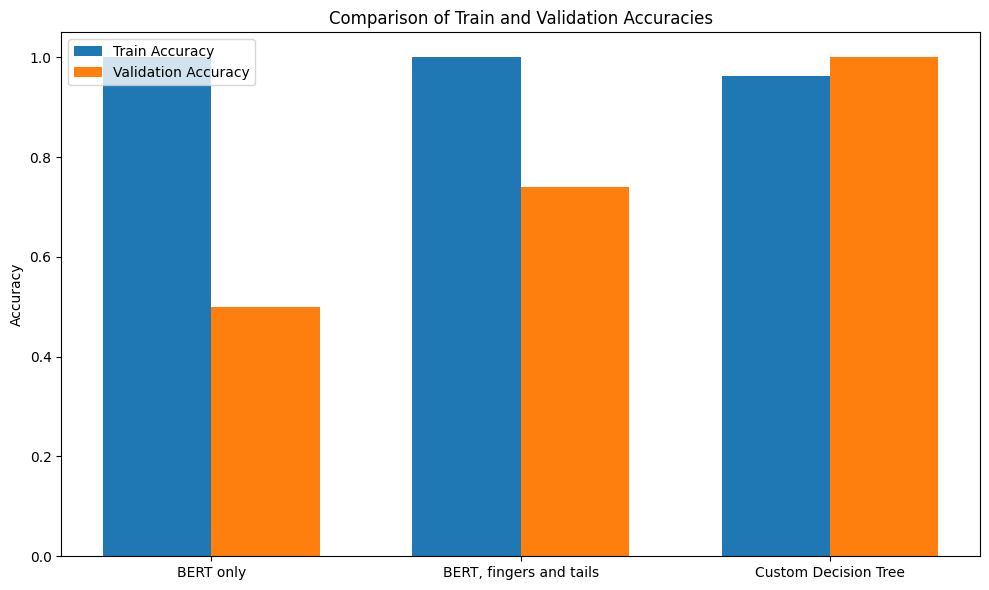

In [162]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

train_accuracies = [results[key]["train"] for key in results]
val_accuracies = [results[key]["val"] for key in results]
labels = list(results.keys())

x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Train and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()